In [1]:
import pandas as pd
import numpy as np
import json

from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, precision_recall_curve, auc

In [2]:
df_labels= 'data.info.txt'
df_labels = pd.read_csv(df_labels, delimiter=',')
list(df_labels['gene_id'])

['ENSG00000004059',
 'ENSG00000004059',
 'ENSG00000004059',
 'ENSG00000004059',
 'ENSG00000004059',
 'ENSG00000004059',
 'ENSG00000004059',
 'ENSG00000004059',
 'ENSG00000004059',
 'ENSG00000004059',
 'ENSG00000004059',
 'ENSG00000004059',
 'ENSG00000004059',
 'ENSG00000004059',
 'ENSG00000004059',
 'ENSG00000004059',
 'ENSG00000004059',
 'ENSG00000004059',
 'ENSG00000003056',
 'ENSG00000003056',
 'ENSG00000003056',
 'ENSG00000003056',
 'ENSG00000003056',
 'ENSG00000003056',
 'ENSG00000003056',
 'ENSG00000003056',
 'ENSG00000003056',
 'ENSG00000003056',
 'ENSG00000003056',
 'ENSG00000003056',
 'ENSG00000003056',
 'ENSG00000003056',
 'ENSG00000003056',
 'ENSG00000003056',
 'ENSG00000003056',
 'ENSG00000003056',
 'ENSG00000003056',
 'ENSG00000003056',
 'ENSG00000003056',
 'ENSG00000003056',
 'ENSG00000003056',
 'ENSG00000003056',
 'ENSG00000003056',
 'ENSG00000003056',
 'ENSG00000003056',
 'ENSG00000003056',
 'ENSG00000003056',
 'ENSG00000003056',
 'ENSG00000003056',
 'ENSG00000003056',


In [3]:
df_labels= 'data.info.txt'
df_labels = pd.read_csv(df_labels, delimiter=',')

df_raw = 'dataset0.json'

# Open the file and read line by line (each line = one sequence)
with open(df_raw, 'r') as file:
    data_list = []
    for line in file:
        try:
            data = json.loads(line) 
            data_list.append(data)
        except json.JSONDecodeError as e:
            print(f"Error decoding JSON on line: {line}")
            print(f"Error message: {e}")

In [4]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

def preprocess_data(data):
    preprocessed_data = []

    for item in data:
        for transcript_id, positions in item.items():
            for position, rna_data in positions.items():
                for rna_sequence, lists in rna_data.items():
                    # Convert lists of lists into a NumPy array
                    data_array = np.array(lists)  # Shape: (n_samples, 9)

                    # Skip empty arrays
                    if data_array.size == 0:
                        continue

                    # Standardize the data
                    scaler = StandardScaler()
                    data_scaled = scaler.fit_transform(data_array)

                    # Store preprocessed data
                    preprocessed_data.append({
                        'transcript_id': transcript_id,
                        'position': position,
                        'rna_sequence': rna_sequence,
                        'data_scaled': data_scaled
                    })

    return preprocessed_data
clean_data = preprocess_data((data_list))

In [118]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from scipy.spatial.distance import euclidean
from tqdm.notebook import tqdm 
from joblib import Parallel, delayed

# KIV DBScan 
        # dbscan = DBSCAN(eps=0.5, min_samples=5)
        # labels = dbscan.fit_predict(data_scaled)


def extract_clustering_features_kmeans(preprocessed_data):
    feature_list = []

    # tqdm just to see progress
    for item in tqdm(preprocessed_data, desc="Processing items"):
        data_scaled = item['data_scaled']

        # Check if there are enough data points for clustering
        if len(data_scaled) < 2:
            continue  # Skip if not enough data points

        # Perform KMeans clustering with 2 clusters
        kmeans = KMeans(n_clusters=2, random_state=42)
        labels = kmeans.fit_predict(data_scaled)
        centroids = kmeans.cluster_centers_

        # Calculate distance between cluster centroids
        centroid_distance = euclidean(centroids[0], centroids[1])

        # Cluster sizes
        unique_labels, counts = np.unique(labels, return_counts=True)
        cluster_sizes = dict(zip(unique_labels, counts))

        # Inertia (within-cluster sum of squares)
        inertia = kmeans.inertia_

        # Silhouette Score (if there are at least 2 clusters)
        if len(set(labels)) > 1:
            silhouette_avg = silhouette_score(data_scaled, labels)
        else:
            silhouette_avg = -1  # Indicate not applicable

        # Variance within each cluster
        variance_cluster_0 = np.var(data_scaled[labels == 0], axis=0).mean()
        variance_cluster_1 = np.var(data_scaled[labels == 1], axis=0).mean()

        # Density estimation (number of points per unit volume)
        # Assuming the volume is proportional to the variance
        density_cluster_0 = cluster_sizes.get(0, 0) / variance_cluster_0 if variance_cluster_0 > 0 else 0
        density_cluster_1 = cluster_sizes.get(1, 0) / variance_cluster_1 if variance_cluster_1 > 0 else 0

        # Compile features
        features = {
            'transcript_id': item['transcript_id'],
            'position': item['position'],
            'rna_sequence': item['rna_sequence'],
            'centroid_distance': centroid_distance,
            'cluster_size_0': cluster_sizes.get(0, 0),
            'cluster_size_1': cluster_sizes.get(1, 0),
            'inertia': inertia,
            'silhouette_score': silhouette_avg,
            'variance_cluster_0': variance_cluster_0,
            'variance_cluster_1': variance_cluster_1,
            'density_cluster_0': density_cluster_0,
            'density_cluster_1': density_cluster_1
        }

        feature_list.append(features)

    return pd.DataFrame(feature_list)

def extract_clustering_features_kmeans_optimized(preprocessed_data):
    feature_list = []

    for item in tqdm(preprocessed_data, desc="Processing items"):
        data_scaled = item['data_scaled']

        if len(data_scaled) < 2:
            continue  # Skip if not enough data points

        # Perform KMeans clustering with 2 clusters
        kmeans = KMeans(n_clusters=2, random_state=42)
        labels = kmeans.fit_predict(data_scaled)
        centroids = kmeans.cluster_centers_

        # Calculate distance between cluster centroids
        centroid_distance = euclidean(centroids[0], centroids[1])

        # Cluster sizes
        unique_labels, counts = np.unique(labels, return_counts=True)
        cluster_sizes = dict(zip(unique_labels, counts))

        # Inertia (within-cluster sum of squares)
        inertia = kmeans.inertia_

        # Silhouette Score (if there are at least 2 clusters)
        silhouette_avg = silhouette_score(data_scaled, labels) if len(set(labels)) > 1 else -1

        # Compile features
        features = {
            'transcript_id': item['transcript_id'],
            'position': item['position'],
            'rna_sequence': item['rna_sequence'],
            'centroid_distance': centroid_distance,
            'cluster_size_0': cluster_sizes.get(0, 0),
            'cluster_size_1': cluster_sizes.get(1, 0),
            'inertia': inertia,
            'silhouette_score': silhouette_avg
        }

        feature_list.append(features)

    return pd.DataFrame(feature_list)

def process_item(item):
    data_scaled = item['data_scaled']

    if len(data_scaled) < 2:
        return None  # Skip if not enough data points

    kmeans = KMeans(n_clusters=2, random_state=42)
    labels = kmeans.fit_predict(data_scaled)
    centroids = kmeans.cluster_centers_

    centroid_distance = euclidean(centroids[0], centroids[1])
    unique_labels, counts = np.unique(labels, return_counts=True)
    cluster_sizes = dict(zip(unique_labels, counts))
    inertia = kmeans.inertia_
    silhouette_avg = silhouette_score(data_scaled, labels) if len(set(labels)) > 1 else -1

    features = {
        'transcript_id': item['transcript_id'],
        'position': item['position'],
        'rna_sequence': item['rna_sequence'],
        'centroid_distance': centroid_distance,
        'cluster_size_0': cluster_sizes.get(0, 0),
        'cluster_size_1': cluster_sizes.get(1, 0),
        'inertia': inertia,
        'silhouette_score': silhouette_avg
    }

    return features

def process_item(item):
    data_scaled = item['data_scaled']

    # Check if there are enough data points for clustering
    if len(data_scaled) < 2:
        return None  # Skip if not enough data points

    # Perform KMeans clustering with 2 clusters
    kmeans = KMeans(n_clusters=2, random_state=42)
    labels = kmeans.fit_predict(data_scaled)
    centroids = kmeans.cluster_centers_

    # Calculate distance between cluster centroids
    centroid_distance = euclidean(centroids[0], centroids[1])

    # Cluster sizes
    unique_labels, counts = np.unique(labels, return_counts=True)
    cluster_sizes = dict(zip(unique_labels, counts))

    # Inertia (within-cluster sum of squares)
    inertia = kmeans.inertia_

    # Silhouette Score (if there are at least 2 clusters)
    if len(set(labels)) > 1:
        silhouette_avg = silhouette_score(data_scaled, labels)
    else:
        silhouette_avg = -1  # Indicate not applicable

    # Variance within each cluster
    variance_cluster_0 = np.var(data_scaled[labels == 0], axis=0).mean()
    variance_cluster_1 = np.var(data_scaled[labels == 1], axis=0).mean()

    # Density estimation (number of points per unit volume)
    # Assuming the volume is proportional to the variance
    density_cluster_0 = (cluster_sizes.get(0, 0) / variance_cluster_0) if variance_cluster_0 > 0 else 0
    density_cluster_1 = (cluster_sizes.get(1, 0) / variance_cluster_1) if variance_cluster_1 > 0 else 0

    # Compile features
    features = {
        'transcript_id': item['transcript_id'],
        'position': item['position'],
        'rna_sequence': item['rna_sequence'],
        'centroid_distance': centroid_distance,
        'cluster_size_0': cluster_sizes.get(0, 0),
        'cluster_size_1': cluster_sizes.get(1, 0),
        'inertia': inertia,
        'silhouette_score': silhouette_avg,
        'variance_cluster_0': variance_cluster_0,
        'variance_cluster_1': variance_cluster_1,
        'density_cluster_0': density_cluster_0,
        'density_cluster_1': density_cluster_1
    }

    return features

def extract_clustering_features_fullversion_parallel(preprocessed_data):
    # Use Parallel processing with all available cores
    results = Parallel(n_jobs=-1)(
        delayed(process_item)(item) for item in tqdm(preprocessed_data, desc="Processing items")
    )

    # Filter out None results (items with less than 2 data points)
    feature_list = [res for res in results if res is not None]

    return pd.DataFrame(feature_list)

def extract_clustering_features_fastversion_parallel(preprocessed_data):
    results = Parallel(n_jobs=-1)(delayed(process_item)(item) for item in tqdm(preprocessed_data))
    feature_list = [res for res in results if res is not None]
    return pd.DataFrame(feature_list)


cluster_data = extract_clustering_features_fullversion_parallel(clean_data)

Processing items:   0%|          | 0/121838 [00:00<?, ?it/s]

In [10]:
### Experimental extracting data by cols instead of rows.

from joblib import Parallel, delayed
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import euclidean
from tqdm.notebook import tqdm
import numpy as np
import pandas as pd

def process_item(item):
    data_scaled = item['data_scaled']  # Shape: (n_samples, 9)
    
    # Check if there are enough data points
    if len(data_scaled) < 2:
        return None  # Skip if not enough data points

    # Split data into three sets
    set1 = data_scaled[:, 0:3]  # Positions 0-2
    set2 = data_scaled[:, 3:6]  # Positions 3-5
    set3 = data_scaled[:, 6:9]  # Positions 6-8

    # Initialize a dictionary to store features
    features = {
        'transcript_id': item['transcript_id'],
        'position': item['position'],
        'rna_sequence': item['rna_sequence']
    }
    
    # List to hold data for each set
    sets = [(set1, 'set1'), (set2, 'set2'), (set3, 'set3')]

    for data_set, set_name in sets:
        # Check if there are enough data points in the set
        if len(data_set) < 2:
            # Fill features with default values
            features.update({
                f'centroid_distance_{set_name}': 0,
                f'cluster_size_0_{set_name}': 0,
                f'cluster_size_1_{set_name}': 0,
                f'inertia_{set_name}': 0,
                f'silhouette_score_{set_name}': -1,
                f'variance_cluster_0_{set_name}': 0,
                f'variance_cluster_1_{set_name}': 0,
                f'density_cluster_0_{set_name}': 0,
                f'density_cluster_1_{set_name}': 0
            })
            continue

        # Perform KMeans clustering with 2 clusters
        kmeans = KMeans(n_clusters=2, random_state=42)
        labels = kmeans.fit_predict(data_set)
        centroids = kmeans.cluster_centers_

        # Calculate distance between cluster centroids
        centroid_distance = euclidean(centroids[0], centroids[1])

        # Cluster sizes
        unique_labels, counts = np.unique(labels, return_counts=True)
        cluster_sizes = dict(zip(unique_labels, counts))

        # Inertia (within-cluster sum of squares)
        inertia = kmeans.inertia_

        # Silhouette Score
        silhouette_avg = silhouette_score(data_set, labels) if len(set(labels)) > 1 else -1

        # Variance within each cluster
        variance_cluster_0 = np.var(data_set[labels == 0], axis=0).mean()
        variance_cluster_1 = np.var(data_set[labels == 1], axis=0).mean()

        # Density estimation
        density_cluster_0 = (cluster_sizes.get(0, 0) / variance_cluster_0) if variance_cluster_0 > 0 else 0
        density_cluster_1 = (cluster_sizes.get(1, 0) / variance_cluster_1) if variance_cluster_1 > 0 else 0

        # Update features dictionary
        features.update({
            f'centroid_distance_{set_name}': centroid_distance,
            f'cluster_size_0_{set_name}': cluster_sizes.get(0, 0),
            f'cluster_size_1_{set_name}': cluster_sizes.get(1, 0),
            f'inertia_{set_name}': inertia,
            f'silhouette_score_{set_name}': silhouette_avg,
            f'variance_cluster_0_{set_name}': variance_cluster_0,
            f'variance_cluster_1_{set_name}': variance_cluster_1,
            f'density_cluster_0_{set_name}': density_cluster_0,
            f'density_cluster_1_{set_name}': density_cluster_1
        })

    return features

def extract_clustering_features_colwise_parallel(preprocessed_data):
    # Use Parallel processing with all available cores
    results = Parallel(n_jobs=-1)(
        delayed(process_item)(item) for item in tqdm(preprocessed_data, desc="Processing items")
    )
    
    # Filter out None results
    feature_list = [res for res in results if res is not None]
    
    return pd.DataFrame(feature_list)

cluster_data = extract_clustering_features_colwise_parallel(clean_data)

Processing items:   0%|          | 0/121838 [00:00<?, ?it/s]

In [11]:
cluster_data.to_pickle("clustered_dat_scaled.pkl")

In [5]:
import numpy as np
import pandas as pd
cluster_data = pd.read_pickle("clustered_dat_noscale.pkl")
pd.set_option('display.max_columns', None)
print(cluster_data.columns)

Index(['transcript_id', 'position', 'rna_sequence', 'centroid_distance_set1',
       'cluster_size_0_set1', 'cluster_size_1_set1', 'inertia_set1',
       'silhouette_score_set1', 'variance_cluster_0_set1',
       'variance_cluster_1_set1', 'density_cluster_0_set1',
       'density_cluster_1_set1', 'centroid_distance_set2',
       'cluster_size_0_set2', 'cluster_size_1_set2', 'inertia_set2',
       'silhouette_score_set2', 'variance_cluster_0_set2',
       'variance_cluster_1_set2', 'density_cluster_0_set2',
       'density_cluster_1_set2', 'centroid_distance_set3',
       'cluster_size_0_set3', 'cluster_size_1_set3', 'inertia_set3',
       'silhouette_score_set3', 'variance_cluster_0_set3',
       'variance_cluster_1_set3', 'density_cluster_0_set3',
       'density_cluster_1_set3'],
      dtype='object')


In [6]:
cluster_data.replace([np.inf, -np.inf], np.nan, inplace=True)
cluster_data.fillna(-1, inplace=True)

In [7]:
# Merge labels with features
cluster_data['position'] = cluster_data['position'].astype(str)
df_labels['transcript_position'] = df_labels['transcript_position'].astype(str)
features_df = cluster_data.merge(df_labels, left_on=['transcript_id', 'position'], right_on=['transcript_id', 'transcript_position'], how='left')

# Fill missing labels with 0 (assuming normal)
features_df['label'].fillna(0, inplace=True)

C:\Users\chewy\AppData\Local\Temp\ipykernel_39200\2793763114.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  features_df['label'].fillna(0, inplace=True)


In [37]:
print(features_df[0:3])
# Observing the format of the df and with the advice of subject knowledge experts, we should not overfit on the same gene id
# the next code block strips out repetitions of gene_id randomly 
label_counts = features_df['label'].value_counts()
print(label_counts)

     transcript_id position rna_sequence  centroid_distance_set1  \
0  ENST00000000233      244      AAGACCA               18.049840   
1  ENST00000000233      261      CAAACTG                5.526989   
2  ENST00000000233      316      GAAACAG                2.326516   

   cluster_size_0_set1  cluster_size_1_set1  inertia_set1  \
0                   11                  174   1780.376015   
1                   48                  124    962.318172   
2                   89                   96    480.179738   

   silhouette_score_set1  variance_cluster_0_set1  variance_cluster_1_set1  \
0               0.784817                 2.265807                 3.267441   
1               0.542727                 3.945362                 1.059640   
2               0.371585                 0.633370                 1.080104   

   ...  cluster_size_1_set3  inertia_set3  silhouette_score_set3  \
0  ...                  135   1213.366521               0.522858   
1  ...                   61    79

In [21]:
def sample_with_ratio(group):
    # Separate the group into label 1 and label 0
    label_1 = group[group['label'] == 1]
    label_0 = group[group['label'] == 0]
    
    # For label_1 data
    if len(label_0) == 0:
        # No label_0 data in group
        # Limit label_1 data to at most 5
        sample_label_1 = label_1.sample(n=min(len(label_1), 3), random_state=42)
        sample_label_0 = pd.DataFrame()  # No label_0 data
    else:
        # Calculate the maximum allowed label_1 instances (5:1 ratio)
        max_label_1 = 5 * len(label_0)
        
        if len(label_1) <= max_label_1:
            # Take all label_1 data
            sample_label_1 = label_1
        else:
            # Sample label_1 data to have len(label_1) = 5 * len(label_0)
            sample_label_1 = label_1.sample(n=max_label_1, random_state=42)
        
        # Limit label_0 data to at most 2 rows per group
        sample_label_0 = label_0.sample(n=min(len(label_0), 2), random_state=42)
    
    # Combine the two samples
    combined_sample = pd.concat([sample_label_1, sample_label_0])
    
    # Limit the total rows to 10 if necessary
    limit = 5
    if len(combined_sample) > limit:
        combined_sample = combined_sample.sample(n=limit, random_state=42)
    
    # Get the remaining data not included in the sample
    sampled_indices = combined_sample.index
    remaining_data = group.drop(sampled_indices)
    
    return combined_sample, remaining_data



sampled_list = []
remaining_list = []

# Group the DataFrame and apply the function
for name, group in features_df.groupby('gene_id'):
    sampled, remaining = sample_with_ratio(group)
    sampled_list.append(sampled)
    remaining_list.append(remaining)

# Combine the lists into DataFrames
df_features_ratioed = pd.concat(sampled_list).reset_index(drop=True)
df_blind_test = pd.concat(remaining_list).reset_index(drop=True)
df_label_1 = df_blind_test[df_blind_test['label'] == 1]

# Filter rows where label == 0 and sample 200 rows
df_label_0 = df_blind_test[df_blind_test['label'] == 0]
df_label_0_sample = df_label_0.sample(n=min(200, len(df_label_0)), random_state=42)

# Combine the two DataFrames
df_label_1 = pd.concat([df_label_1, df_label_0_sample], ignore_index=True)

label_counts = df_features_ratioed['label'].value_counts()
print(label_counts)
label_counts = df_blind_test['label'].value_counts()
print(label_counts)
label_counts = df_label_1['label'].value_counts()
print(label_counts)

X_test_full = features_df.drop(['transcript_id', 'position', 'rna_sequence', 'label', 'transcript_position', 'gene_id'], axis=1)
y_test_full = features_df['label']
X_test_blind = df_blind_test.drop(['transcript_id', 'position', 'rna_sequence', 'label', 'transcript_position', 'gene_id'], axis=1)
y_test_blind = df_blind_test['label']

X_test_blind_lab1 = df_label_1.drop(['transcript_id', 'position', 'rna_sequence', 'label', 'transcript_position', 'gene_id'], axis=1)
y_test_blind_lab1 = df_label_1['label']

label
0    7281
1    3544
Name: count, dtype: int64
label
0    109082
1      1931
Name: count, dtype: int64
label
1    1931
0     200
Name: count, dtype: int64


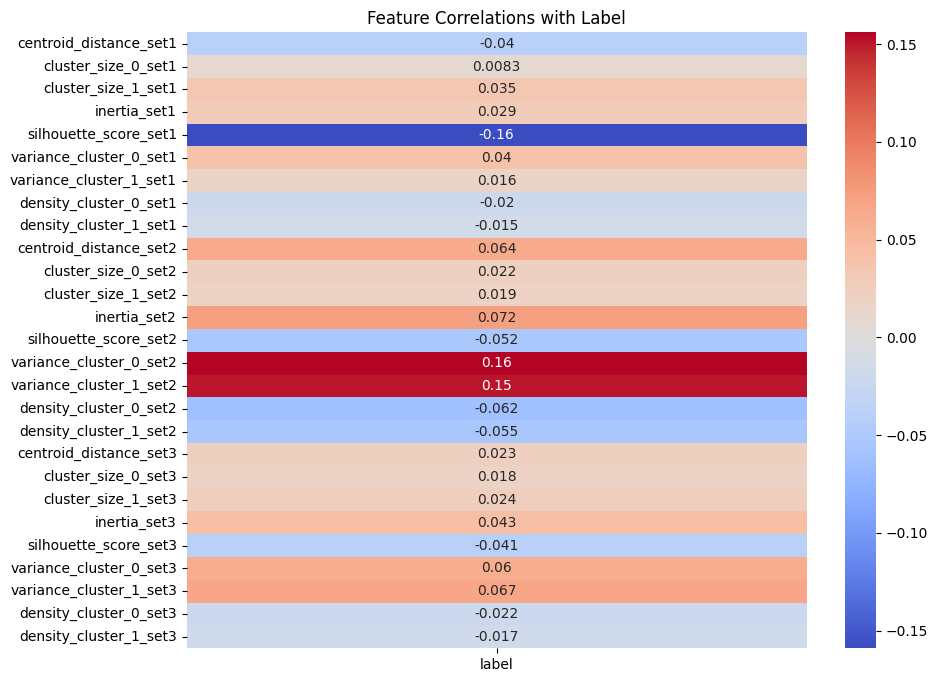

In [22]:
### Start of training models
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# FOR REFERENCE
# df_features_ratioed = raw data set pre train-test split and pre SMOTE and pre dropping of cols

df = df_features_ratioed.drop(['transcript_id', 'position', 'rna_sequence', 'transcript_position', 'gene_id'], axis=1)

correlation_matrix = df.corr()
label_correlation = correlation_matrix['label'].drop('label')
plt.figure(figsize=(10, 8))
sns.heatmap(label_correlation.to_frame(), annot=True, cmap='coolwarm', cbar=True)

# Show the plot
plt.title('Feature Correlations with Label')
plt.show()

X = df_features_ratioed.drop(['transcript_id', 'position', 'rna_sequence', 'label', 'transcript_position', 'gene_id'], axis=1)
y = df_features_ratioed['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [23]:
### SMOTE ENHANCEMENT
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt

# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Print the class distribution before and after applying SMOTE
print("Original class distribution:", dict(zip(*np.unique(y_train, return_counts=True))))
print("Class distribution after SMOTE:", dict(zip(*np.unique(y_train_smote, return_counts=True))))

Original class distribution: {0: 5827, 1: 2833}
Class distribution after SMOTE: {0: 5827, 1: 5827}


In [24]:
# For y_train
train_ratios = y_train.value_counts(normalize=True)
print("Class distribution in y_train:")
print(train_ratios)

# For y_test
test_ratios = y_test.value_counts(normalize=True)
print("\nClass distribution in y_test:")
print(test_ratios)

# For y_train_smote
test_ratios = y_train_smote.value_counts(normalize=True)
print("\nClass distribution in y_test:")
print(test_ratios)


Class distribution in y_train:
label
0    0.672864
1    0.327136
Name: proportion, dtype: float64

Class distribution in y_test:
label
0    0.671594
1    0.328406
Name: proportion, dtype: float64

Class distribution in y_test:
label
0    0.5
1    0.5
Name: proportion, dtype: float64


In [25]:
### RANDOM FOREST
print("Classic RF")
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
y_pred_proba = clf.predict_proba(X_test)[:, 1]

accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
pr_auc = auc(recall, precision)  # Calculate PR AUC
report = classification_report(y_test, y_pred)

# Output the results
print(f"Accuracy: {accuracy}")
print(f"ROC AUC: {roc_auc}")
print(f"PR AUC: {pr_auc}")
print(report)

print("Results on extra blind test set of the thrown away samples")
y_pred = clf.predict(X_test_blind)
y_pred_proba = clf.predict_proba(X_test_blind)[:, 1]

accuracy = accuracy_score(y_test_blind, y_pred)
roc_auc = roc_auc_score(y_test_blind, y_pred_proba)
precision, recall, _ = precision_recall_curve(y_test_blind, y_pred_proba)
pr_auc = auc(recall, precision)  # Calculate PR AUC
report = classification_report(y_test_blind, y_pred)

# Output the results
print(f"Accuracy: {accuracy}")
print(f"ROC AUC: {roc_auc}")
print(f"PR AUC: {pr_auc}")
print(report)

print("results on extra blind test set with mostly label 1s!")
y_pred = clf.predict(X_test_blind_lab1)
y_pred_proba = clf.predict_proba(X_test_blind_lab1)[:, 1]

accuracy = accuracy_score(y_test_blind_lab1, y_pred)
roc_auc = roc_auc_score(y_test_blind_lab1, y_pred_proba)
precision, recall, _ = precision_recall_curve(y_test_blind_lab1, y_pred_proba)
pr_auc = auc(recall, precision)  # Calculate PR AUC
report = classification_report(y_test_blind_lab1, y_pred)

# Output the results
print(f"Accuracy: {accuracy}")
print(f"ROC AUC: {roc_auc}")
print(f"PR AUC: {pr_auc}")
print(report)

print("Training SMOTE Enhanced Model")

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train_smote, y_train_smote)

y_pred = clf.predict(X_test)
y_pred_proba = clf.predict_proba(X_test)[:, 1]

accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
pr_auc = auc(recall, precision)  # Calculate PR AUC
report = classification_report(y_test, y_pred)

# Output the results
print(f"Accuracy: {accuracy}")
print(f"ROC AUC: {roc_auc}")
print(f"PR AUC: {pr_auc}")
print(report)

Classic RF
Accuracy: 0.7113163972286374
ROC AUC: 0.7246999885857337
PR AUC: 0.5558381568929418
              precision    recall  f1-score   support

           0       0.73      0.91      0.81      1454
           1       0.62      0.30      0.41       711

    accuracy                           0.71      2165
   macro avg       0.68      0.61      0.61      2165
weighted avg       0.69      0.71      0.68      2165

Results on extra blind test set of the thrown away samples
Accuracy: 0.8857881509372776
ROC AUC: 0.7332613345453247
PR AUC: 0.051827178163753096
              precision    recall  f1-score   support

           0       0.99      0.90      0.94    109082
           1       0.05      0.34      0.09      1931

    accuracy                           0.89    111013
   macro avg       0.52      0.62      0.52    111013
weighted avg       0.97      0.89      0.92    111013

results on extra blind test set with mostly label 1s!
Accuracy: 0.39230408259033317
ROC AUC: 0.72714008285

In [26]:
### XGBoost
print("CLASSIC XGBOOST")
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba) 
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
pr_auc = auc(recall, precision)  # Calculate PR AUC
report = classification_report(y_test, y_pred)

# Output the results
print(f"Accuracy: {accuracy}")
print(f"ROC AUC: {roc_auc}")
print(f"PR AUC: {pr_auc}")
print(report)
print("SMOTE Enhancement:")

model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model.fit(X_train_smote, y_train_smote)
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba) 
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
pr_auc = auc(recall, precision)  # Calculate PR AUC
report = classification_report(y_test, y_pred)

# Output the results
print(f"Accuracy: {accuracy}")
print(f"ROC AUC: {roc_auc}")
print(f"PR AUC: {pr_auc}")
print(report)

CLASSIC XGBOOST


c:\Users\chewy\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [20:12:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.6988452655889146
ROC AUC: 0.7153881721116586
PR AUC: 0.5551478947158819
              precision    recall  f1-score   support

           0       0.75      0.83      0.79      1454
           1       0.55      0.43      0.49       711

    accuracy                           0.70      2165
   macro avg       0.65      0.63      0.64      2165
weighted avg       0.69      0.70      0.69      2165

SMOTE Enhancement:


c:\Users\chewy\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [20:12:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.6766743648960739
ROC AUC: 0.7063235035219783
PR AUC: 0.5288494767896738
              precision    recall  f1-score   support

           0       0.77      0.74      0.75      1454
           1       0.51      0.56      0.53       711

    accuracy                           0.68      2165
   macro avg       0.64      0.65      0.64      2165
weighted avg       0.69      0.68      0.68      2165



In [27]:
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2]
}

xgb_clf = xgb.XGBClassifier(random_state=42)

# Perform Randomized Search
random_search = RandomizedSearchCV(
    estimator=xgb_clf,
    param_distributions=param_grid,
    n_iter=50,
    scoring='roc_auc',
    cv=3,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train, y_train)

# Best parameters
print("Best parameters found: ", random_search.best_params_)


Best parameters found:  {'subsample': 0.8, 'n_estimators': 500, 'max_depth': 9, 'learning_rate': 0.01, 'gamma': 0.2, 'colsample_bytree': 0.8}


In [28]:
best_params = random_search.best_params_

model = XGBClassifier(random_state=42, **best_params)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba) 
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
pr_auc = auc(recall, precision)  # Calculate PR AUC
report = classification_report(y_test, y_pred)

# Output the results
print(f"Accuracy: {accuracy}")
print(f"ROC AUC: {roc_auc}")
print(f"PR AUC: {pr_auc}")
print(report)

print("SMOTE Enhancement:")

model = XGBClassifier(random_state=42, **best_params)
model.fit(X_train_smote, y_train_smote)
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba) 
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
pr_auc = auc(recall, precision)  # Calculate PR AUC
report = classification_report(y_test, y_pred)

# Output the results
print(f"Accuracy: {accuracy}")
print(f"ROC AUC: {roc_auc}")
print(f"PR AUC: {pr_auc}")
print(report)

Accuracy: 0.7247113163972286
ROC AUC: 0.7423152001269111
PR AUC: 0.5783679576504934
              precision    recall  f1-score   support

           0       0.75      0.89      0.81      1454
           1       0.63      0.38      0.48       711

    accuracy                           0.72      2165
   macro avg       0.69      0.64      0.65      2165
weighted avg       0.71      0.72      0.70      2165

SMOTE Enhancement:
Accuracy: 0.6859122401847575
ROC AUC: 0.7361853522074997
PR AUC: 0.5586057078808259
              precision    recall  f1-score   support

           0       0.79      0.73      0.76      1454
           1       0.52      0.59      0.55       711

    accuracy                           0.69      2165
   macro avg       0.65      0.66      0.66      2165
weighted avg       0.70      0.69      0.69      2165



In [29]:
y_pred = model.predict(X_test_full)
y_pred_proba = model.predict_proba(X_test_full)[:, 1]

accuracy = accuracy_score(y_test_full, y_pred)
roc_auc = roc_auc_score(y_test_full, y_pred_proba) 
precision, recall, _ = precision_recall_curve(y_test_full, y_pred_proba)
pr_auc = auc(recall, precision)  # Calculate PR AUC
report = classification_report(y_test_full, y_pred)

# Output the results
print(f"Accuracy: {accuracy}")
print(f"ROC AUC: {roc_auc}")
print(f"PR AUC: {pr_auc}")
print(report)


Accuracy: 0.729796943482329
ROC AUC: 0.8429601690851143
PR AUC: 0.23335550417218937
              precision    recall  f1-score   support

           0       0.99      0.73      0.84    116363
           1       0.12      0.81      0.21      5475

    accuracy                           0.73    121838
   macro avg       0.55      0.77      0.52    121838
weighted avg       0.95      0.73      0.81    121838



In [46]:
print(y_test_blind.value_counts())
smote = SMOTE(random_state=42)
X_test_blind_smote, y_test_blind_smote = smote.fit_resample(X_test_blind, y_test_blind)
print(y_test_blind_smote.value_counts())

label
0    108804
1       792
Name: count, dtype: int64
label
0    108804
1    108804
Name: count, dtype: int64


In [47]:
print("XGBoost fine-tuned extra tests")
print("Results on extra blind test set of the thrown away samples")

y_pred = model.predict(X_test_blind)
y_pred_proba = model.predict_proba(X_test_blind)[:, 1]

accuracy = accuracy_score(y_test_blind, y_pred)
roc_auc = roc_auc_score(y_test_blind, y_pred_proba) 
precision, recall, _ = precision_recall_curve(y_test_blind, y_pred_proba)
pr_auc = auc(recall, precision)  # Calculate PR AUC
report = classification_report(y_test_blind, y_pred)

# Output the results
print(f"Accuracy: {accuracy}")
print(f"ROC AUC: {roc_auc}")
print(f"PR AUC: {pr_auc}")
print(report)

print("Results on extra smoted-blind test set of the thrown away samples")

y_pred = model.predict(X_test_blind_smote)
y_pred_proba = model.predict_proba(X_test_blind_smote)[:, 1]

accuracy = accuracy_score(y_test_blind_smote, y_pred)
roc_auc = roc_auc_score(y_test_blind_smote, y_pred_proba) 
precision, recall, _ = precision_recall_curve(y_test_blind_smote, y_pred_proba)
pr_auc = auc(recall, precision)  # Calculate PR AUC
report = classification_report(y_test_blind_smote, y_pred)

# Output the results
print(f"Accuracy: {accuracy}")
print(f"ROC AUC: {roc_auc}")
print(f"PR AUC: {pr_auc}")
print(report)

print("results on extra blind test set with mostly label 1s!")
y_pred = model.predict(X_test_blind_lab1)
y_pred_proba = model.predict_proba(X_test_blind_lab1)[:, 1]

accuracy = accuracy_score(y_test_blind_lab1, y_pred)
roc_auc = roc_auc_score(y_test_blind_lab1, y_pred_proba)
precision, recall, _ = precision_recall_curve(y_test_blind_lab1, y_pred_proba)
pr_auc = auc(recall, precision)  # Calculate PR AUC
report = classification_report(y_test_blind_lab1, y_pred)

# Output the results
print(f"Accuracy: {accuracy}")
print(f"ROC AUC: {roc_auc}")
print(f"PR AUC: {pr_auc}")
print(report)


XGBoost fine-tuned extra tests
Results on extra blind test set of the thrown away samples
Accuracy: 0.7003266542574547
ROC AUC: 0.7549447755931432
PR AUC: 0.026170178578692423
              precision    recall  f1-score   support

           0       1.00      0.70      0.82    108804
           1       0.02      0.67      0.03       792

    accuracy                           0.70    109596
   macro avg       0.51      0.69      0.43    109596
weighted avg       0.99      0.70      0.82    109596

Results on extra smoted-blind test set of the thrown away samples
Accuracy: 0.7567920297047903
ROC AUC: 0.8382636435253279
PR AUC: 0.8320363537345865
              precision    recall  f1-score   support

           0       0.79      0.70      0.74    108804
           1       0.73      0.81      0.77    108804

    accuracy                           0.76    217608
   macro avg       0.76      0.76      0.76    217608
weighted avg       0.76      0.76      0.76    217608

results on extra bli

In [48]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc, classification_report, accuracy_score

#Note:using non scaled pkl file yields better results

# Define the neural network model
class MLP(nn.Module):
    def __init__(self, input_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, 256)
        self.bn1 = nn.BatchNorm1d(256)
        self.dropout1 = nn.Dropout(0.5)
        
        self.fc2 = nn.Linear(256, 128)
        self.bn2 = nn.BatchNorm1d(128)
        self.dropout2 = nn.Dropout(0.5)
        
        self.fc3 = nn.Linear(128, 64)
        self.bn3 = nn.BatchNorm1d(64)
        self.dropout3 = nn.Dropout(0.5)
        
        self.fc4 = nn.Linear(64, 32)
        self.bn4 = nn.BatchNorm1d(32)
        self.dropout4 = nn.Dropout(0.5)
        
        self.fc5 = nn.Linear(32, 1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x = torch.relu(self.bn1(self.fc1(x)))
        x = self.dropout1(x)
        
        x = torch.relu(self.bn2(self.fc2(x)))
        x = self.dropout2(x)
        
        x = torch.relu(self.bn3(self.fc3(x)))
        x = self.dropout3(x)
        
        x = torch.relu(self.bn4(self.fc4(x)))
        x = self.dropout4(x)
        
        x = self.sigmoid(self.fc5(x))
        return x

# Initialize the model, loss function, and optimizer
input_size = X_train.shape[1]  # Number of features
model = MLP(input_size)

# Use Binary Cross Entropy Loss (same as binary cross-entropy in Keras)
criterion = nn.BCELoss()

# Use Adam optimizer with a lower learning rate to improve performance
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Convert the training data to PyTorch tensors
X_train_torch = torch.tensor(X_train.values, dtype=torch.float32)
y_train_torch = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)  # Make y_train a column vector
X_test_torch = torch.tensor(X_test.values, dtype=torch.float32)
y_test_torch = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1) 

# Training the model
num_epochs = 500
batch_size = 32

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()

    # Forward pass
    outputs = model(X_train_torch)
    loss = criterion(outputs, y_train_torch)

    # Backward pass and optimization
    loss.backward()
    optimizer.step()

    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Evaluation
model.eval()
with torch.no_grad():
    y_pred_proba = model(X_test_torch).numpy().flatten()
    y_pred = (y_pred_proba > 0.5).astype(int)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
pr_auc = auc(recall, precision)
report = classification_report(y_test, y_pred)

# Output the results
print(f"Accuracy: {accuracy}")
print(f"ROC AUC: {roc_auc}")
print(f"PR AUC: {pr_auc}")
print(report)


Epoch [10/500], Loss: 0.6685
Epoch [20/500], Loss: 0.6522
Epoch [30/500], Loss: 0.6430
Epoch [40/500], Loss: 0.6380
Epoch [50/500], Loss: 0.6380
Epoch [60/500], Loss: 0.6355
Epoch [70/500], Loss: 0.6311
Epoch [80/500], Loss: 0.6310
Epoch [90/500], Loss: 0.6311
Epoch [100/500], Loss: 0.6265
Epoch [110/500], Loss: 0.6299
Epoch [120/500], Loss: 0.6290
Epoch [130/500], Loss: 0.6261
Epoch [140/500], Loss: 0.6273
Epoch [150/500], Loss: 0.6279
Epoch [160/500], Loss: 0.6250
Epoch [170/500], Loss: 0.6237
Epoch [180/500], Loss: 0.6233
Epoch [190/500], Loss: 0.6235
Epoch [200/500], Loss: 0.6211
Epoch [210/500], Loss: 0.6211
Epoch [220/500], Loss: 0.6177
Epoch [230/500], Loss: 0.6175
Epoch [240/500], Loss: 0.6173
Epoch [250/500], Loss: 0.6161
Epoch [260/500], Loss: 0.6154
Epoch [270/500], Loss: 0.6145
Epoch [280/500], Loss: 0.6125
Epoch [290/500], Loss: 0.6091
Epoch [300/500], Loss: 0.6105
Epoch [310/500], Loss: 0.6086
Epoch [320/500], Loss: 0.6049
Epoch [330/500], Loss: 0.6063
Epoch [340/500], Lo